$$ y_{in} = F_{act}((Im+n_{in} W_{in}) + bias) $$
$$ Im^* = F_{act}(y_{in} W_{in}^T) + n_{out} $$

$$ Cost = \sqrt{\langle|Im-Im^*|\rangle} + \lambda \langle r \rangle $$

In [2]:
class aec_model(object):
    
    def __init__(self, params):
        params = self.add_params(params)
        self.params = params
        self.make_dirs()
        self.graph = self.make_graph()

    def add_params(self, params):  
        params['compression'] = params['imxlen'] * params['imylen'] / params['nneurons']
        params['savefolder'] = str('./output/image_output/' + 
                                   str(params['ims'])+
                                   '_nonlin1_' + str(params['nonlin1'])+ 
                                   '_nonlin2_' + str(params['nonlin2'])+
                                   '_neurons_'+ str(params['nneurons'])+
                                   '_nin_'+ str(params['noise_x'])+
                                   '_nout_'+ str(params['noise_r'])+
                                   '_bsze_'+ str(params['batchsize'])+
                                   '_epochs_'+ str(params['epochs'])+
                                   '_lrate_'+ str(params['learning_rate'])+
                                   '_lambda_act'+ str(params['lambda_act'])+
                                   '_lambda_wgt' + str(params['lambda_wgt'])+ '/')

        return(params)
        
    def make_dirs(self):
        if not os.path.exists(self.params['savefolder']):
            os.makedirs(self.params['savefolder'])
        else:
            filelist = [f for f in os.listdir(self.params['savefolder'])]
            for f in filelist:
                os.remove(self.params['savefolder']+f)
        
    def make_graph(self):
    
        print('Compressing by',self.params['compression'],'for a total of',self.params['nneurons'],'neurons')

        #setup our graph
        #tf.reset_default_graph()
        mygraph = tf.Graph()
        with mygraph.as_default():

            #input images
            with tf.name_scope('input'):
                self.x = tf.placeholder(tf.float32, shape=[self.params["batchsize"], 
                                                           self.params["imxlen"]*self.params["imylen"]])

            #activation function type
            with tf.name_scope('nonliearities'):
                self.nonlin1 = self.params['nonlin1']
                self.nonlin2  = self.params['nonlin2']

            #noises
            with tf.name_scope('noises'):
                self.noisexsigma = self.params['noise_x']
                self.noisersigma = self.params['noise_r']

            #function to add noise
            with tf.name_scope("add_noise"):
                def add_noise(input_layer, std):
                    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
                    return tf.add(input_layer,noise)
            
            #control activation with gamma
            #self.gamma = tf.Variable(tf.ones(self.params['nneurons'], dtype=tf.float32), trainable=False)
            #self.alpha = tf.constant(self.params['alpha'])
                              
            #weights
            with tf.variable_scope("weights"):

                #per Salimans et al 2016 - Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks parameterize weights as w = g/||v||*v. Now ||w|| = g and we can set g to 1 to enfoce this constraint, and learn the direction of the weights v, while maintaining magnitude of norm 1.

                weights_kernel_in = tf.random_normal([self.params['imxlen']*self.params['imylen'],
                                                      self.params['nneurons']],
                                                     dtype=tf.float32,stddev=0.1)
                
                weights_kernel_out = tf.random_normal([self.params['nneurons'],
                                                   self.params['imxlen']*self.params['imylen']],
                                                   dtype=tf.float32,stddev=0.1)
                
                self.win = tf.get_variable('win',initializer=weights_kernel_in)
                

                self.wout = tf.get_variable('wout',initializer=weights_kernel_out)
                

            #bias
            with tf.variable_scope("in_bias"):
                offset = 0 #to keep values positive
                self.inbias = tf.Variable(tf.random_normal([self.params['nneurons']],
                                                         dtype=tf.float32,
                                                         stddev=0.1)+offset)
            with tf.variable_scope("out_bias"):
                offset = 0
                if(params['nonlin2']in['sigmoid','relu','tanh']):
                    self.outbias = tf.Variable(tf.random_normal([self.params['imxlen']*self.params['imylen']],
                                                                dtype=tf.float32,
                                                                stddev=0.1)+offset)
                else:
                    self.outbias = tf.zeros([self.params['imxlen']*self.params['imylen']])
            #lambda
            with tf.name_scope('lambda_activation'):
                self.lambda_act = self.params['lambda_act']
                
            #lambda2
            with tf.name_scope('lambda_weights'):
                self.lambda_wgt = self.params['lambda_wgt']                

            #learning_rate
            with tf.name_scope('learning_rate'):
                self.learning_rate = self.params['learning_rate']

            #nonlienarities
            with tf.name_scope("nonlienarities"):
                #define nonlinearities
                def tanh_fun(bias,arg):
                    return tf.nn.tanh(tf.add(arg,bias)) 
                def sigmoid_fun(bias,arg):
                    return tf.nn.sigmoid(tf.add(arg,bias)) 
                def relu_fun(bias,arg):
                    return tf.nn.relu(tf.add(arg,bias)) 
                def no_fun(bias,arg):
                    return arg

            #encoding part of model
            with tf.name_scope("encoding"):
                linearin = tf.matmul(add_noise(self.x,self.params['noise_x']),self.win) #add noise to input, and multiply by weights
                self.yin = tf.case({tf.equal(self.nonlin1,'tanh'): (lambda: tanh_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'sigmoid'): (lambda: sigmoid_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'relu'): (lambda: relu_fun(self.inbias,linearin))},
                               default=(lambda: no_fun(self.inbias,linearin)),
                               exclusive=True)
                self.yin_noised = add_noise(self.yin,self.params['noise_r'])


            #output part of model
            with tf.name_scope("decoding"):
                #calculate output (reconstruction)
                linearout = tf.matmul(self.yin_noised,self.wout) #add noise to inner layer, and multiply by weight  transpose
                self.xp = tf.case({tf.equal(self.nonlin2,'tanh'): (lambda: tanh_fun(self.outbias,linearout)),
                                   tf.equal(self.nonlin2,'sigmoid'): (lambda: sigmoid_fun(self.outbias,linearout)),
                                   tf.equal(self.nonlin2,'relu'): (lambda: relu_fun(self.outbias,linearout))},
                                   default=(lambda: no_fun(self.outbias,linearout)),
                                   exclusive=True, name='output_nonlienarity')
            
            #how well are we reconstructing?
            with tf.name_scope("reconstruction"):
                self.normalize_recon = False
                if self.normalize_recon == True:
                    normx = self.x - tf.reduce_min(self.x,axis=0)
                    normxp = self.xp - tf.reduce_min(self.xp, axis=0)
                else:
                    normx = self.x
                    normxp = self.xp
                #caclculate redonstruction error.
                self.recon_err = tf.norm(normx-normxp,ord=2)
            
            #calculate cost
            with tf.name_scope("cost_function"):
                self.activation = tf.reduce_mean(self.yin,axis=0)
                self.cost = (tf.reduce_mean(self.recon_err) +
                             self.lambda_act * tf.norm(self.activation,ord=1) + 
                             self.lambda_wgt * tf.norm(self.wout, ord=1))

            #update lambda
            #with tf.name_scope('lambda_update'):
            #    self.lambd = self.lambd * (activation/self.params["batchsize"])
                                     
            #train our model
            with tf.name_scope("training_step"):
                self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
                #self.train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cost)
                
            # create a summary for our cost, im, reconstruction, & weights
            with tf.name_scope('cost_viz'):
                tf.summary.scalar("cost", self.cost)

            with tf.name_scope('image_viz'):    
                x_t = tf.reshape(self.x,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("image", x_t, max_outputs=self.params["batchsize"])

            with tf.name_scope('recon_viz'):
                xp_t = tf.reshape(self.xp,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("recon", xp_t,max_outputs=self.params["batchsize"])

            with tf.name_scope('inweights_viz'):    
                inwin_t = tf.reshape(tf.transpose(self.win),
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("inweights", inwin_t, max_outputs=self.params['nneurons'])
                
            with tf.name_scope('outweights_viz'):    
                outwin_t = tf.reshape(self.wout,
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("outweights", outwin_t, max_outputs=self.params['nneurons'])

            # merge all summaries into a single "operation" which we can execute in a session 
            self.summary_op = tf.summary.merge_all()

        return(mygraph)


In [3]:
#make session and train model
def train_model(aec):
    #with tf.device("/gpu:0"):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True #don't allocate the entire GPU's memory
    config.log_device_placement=True #tell me where devices are placed
    with tf.Session(graph = aec.graph, config=config) as sess:

        #initialize vars
        init = tf.global_variables_initializer()
        sess.run(init)

        #summary writer for tensorboard
        writer = tf.summary.FileWriter(aec.params['savefolder'],
                                       graph=tf.get_default_graph())

        #save evolution of system over training
        cost_evolution = []
        wmean_evolution = []

        inweights_evolution = []
        outweights_evolution = []
        inbias_evolution = []
        activation_evolution = []
        #gamma_evolution = []
        #gamma_assign_evolution = []

        activations = []

        images = []
        recons = []
        print('neurons={}, noise_in={}, noise_out={}, lambda_w={}, lambda_act={}'
              .format(aec.params['nneurons'],
                      aec.params['noise_x'],
                      aec.params['noise_r'],
                      aec.params['lambda_wgt'],
                      aec.params['lambda_act']))

        print('Training {} iterations in {} epochs... '.format(aec.params['iterations'],
                                                               aec.params['epochs']))
        for epoch in range(aec.params['epochs']):
            #print('Epoch {}: '.format(epoch+1))
            np.random.shuffle(vhimgs)
            for ii in range(aec.params['iterations']):

                #reshape our images for feeding to dict
                image = np.reshape(vhimgs[ii*aec.params['batchsize']:(1+ii)*aec.params['batchsize'],:,:],
                                   (aec.params['batchsize'],
                                    aec.params['imxlen']*aec.params['imylen'])).astype(np.float32)

                #setup params to send to dictionary
                feeddict = {aec.x: image}

                #run our session
                sess.run(aec.train_step, feed_dict=feeddict)

                #save evolution of params
                objcost, inws, acts = sess.run([aec.recon_err, aec.win, aec.yin], feed_dict=feeddict)  #aec.cost
                cost_evolution.append(objcost)
                wmean_evolution.append(np.mean(np.abs(inws)))

                activations.append(np.mean(acts))
                
                #save detailed parameters 10 times over the total evolution
                if(ii%(int((aec.params['iterations']*aec.params['epochs'])/10))==0):
                    print(str(ii)+', ',end="")
                    #dump our params
                    win, wout, img, recon, inbias, activation = sess.run([aec.win, aec.wout, aec.x, aec.xp, aec.inbias, aec.activation], feed_dict=feeddict)
                    #save our weights, image, and reconstruction
                    inweights_evolution.append(win)
                    outweights_evolution.append(wout)
                    inbias_evolution.append(inbias)
                    activation_evolution.append(activation)
                    #gamma_evolution.append(gamma)
                    #gamma_assign_evolution.append(gamma)
                    
                    imshape = [aec.params['batchsize'],
                               aec.params['imxlen'],
                               aec.params['imylen']]           
                    images.append(np.reshape(img, imshape))
                    recons.append(np.reshape(recon, imshape))
                #assign gamma
                #sess.run(aec.assign_gamma, feed_dict=feeddict)
                
        #summarize final params
        print('Saving...')
        summary, objcost, inws, outws, acts = sess.run([aec.summary_op, aec.cost, aec.win, aec.wout, aec.yin], feed_dict=feeddict)
        cost_evolution.append(objcost)
        wmean_evolution.append(np.mean(inws))
        activations.append(np.mean(acts))
        final_inweights = aec.win
        final_outweights = aec.wout
        writer.add_summary(summary,ii)
        writer.close()

        print('Done!')

        return(cost_evolution,
               activations,
               wmean_evolution,
               inweights_evolution,
               outweights_evolution,
               images,
               recons,
               final_inweights,
               final_outweights,
               inbias_evolution, 
               activation_evolution
               )
               #gamma_evolution,
               #gamma_assign_evolution)

In [28]:
#set parameters for parameter sweep
params = {} #make a dictionary

#parameters constant for all
params["patchsize"] = 16
params["ims"] = ims
params["patch_multiplier"] = patch_multiplier

with tf.device('/cpu:0'):
    try:
        vhimgs
    except NameError:
        vhimgs, nimages = imr.check_n_load_ims(params['ims'], params['patchsize'], params['patch_multiplier'])

params["nimages"] = nimages
params["imxlen"] = params["patchsize"]
params["imylen"] = params["patchsize"]

#params for sweeping
sweep_neurons = [100]
sweep_nonlin1 = ['sigmoid'] #'sigmoid',
sweep_nonlin2 = ['linear']
sweep_lambda_wgt = [0.1] #[0 , 0.1] #, 0.01, 0.005] #, 0, 0.1, 0.01, 0.005 #0, 0.1, 
sweep_lambda_act = [0] #[0.001, 0.0005, 0.0001] #[0.0, 0.02, 0.05, 0.1, 0.01, 0.005] #0.02, 0.05, 0.1, 0.01, 0.005
#sweep_alpha = [0.0, 0.0001, 0.001, 0.01] #, 0.1, 1.0]
bsis = [1000] #[100, 500, 1000] #100, 1000
sweep_batch_its = [[bsz, int((np.int(params['nimages']/bsz)))] for bsz in bsis] 
sweep_epochs = [50]
sweep_learning_rates = [0.01] #, 0.001, 0.005, 0.01, 0.015] 
sweep_noise_xs_rs = [[0,0]] #,[0.1,0.5],[0.2,1]]#,[0.5,2]] #[[0.,0.], [0.05,0.5], [0.2,1], [0.3,2.5]] #[0.,0.], [0.05,0.5], [0.2,1], [0.3,2.5]

In [29]:
for neurons in sweep_neurons:
    params['nneurons'] = neurons
    for nonlin1 in sweep_nonlin1:
        params['nonlin1'] = nonlin1
        for nonlin2 in sweep_nonlin2:
            params['nonlin2'] = nonlin2
            for lambda_wgt in sweep_lambda_wgt:
                params['lambda_wgt'] = lambda_wgt
                for lambda_act in sweep_lambda_act:
                    params['lambda_act'] = lambda_act
                    for batchsize, iterations in sweep_batch_its:
                        params['batchsize'] = batchsize
                        params['iterations'] = iterations
                        for epos in sweep_epochs:
                            params['epochs'] = epos
                            for lr in sweep_learning_rates:
                                params['learning_rate'] = lr
                                for xs,rs in sweep_noise_xs_rs:
                                    params['noise_x'] = xs
                                    params['noise_r'] = rs

                                    #make our model
                                    aec = aec_model(params)
                                    #train it'
                                    [cost_evolution,
                                     activations,
                                     wmean_evolution,
                                     inweights_evolution,
                                     outweights_evolution,
                                     images,
                                     recons,
                                     final_inweights,
                                     final_outweights, 
                                     inbias_evolution, 
                                     activation_evolution] = train_model(aec)

                                    #save model
                                    print('saving plots')
                                    plu.save_plots(aec,
                                                   activations,
                                                   cost_evolution,
                                                   wmean_evolution,
                                                   inweights_evolution,
                                                   outweights_evolution,
                                                   images,
                                                   recons,
                                                   final_inweights,
                                                   final_outweights,
                                                   inbias_evolution, 
                                                   activation_evolution)
print("*** Parameter Sweep Finished! ***")

Compressing by 2.56 for a total of 100 neurons
neurons=100, noise_in=0, noise_out=0, lambda_w=0.1, lambda_act=0
Training 76 iterations in 50 epochs... 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Saving...
Done!
saving plots


/home/vasha/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/vasha/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


*** Parameter Sweep Finished! ***


(<matplotlib.figure.Figure at 0x7f6700564e10>,
 <matplotlib.image.AxesImage at 0x7f67030d3668>)

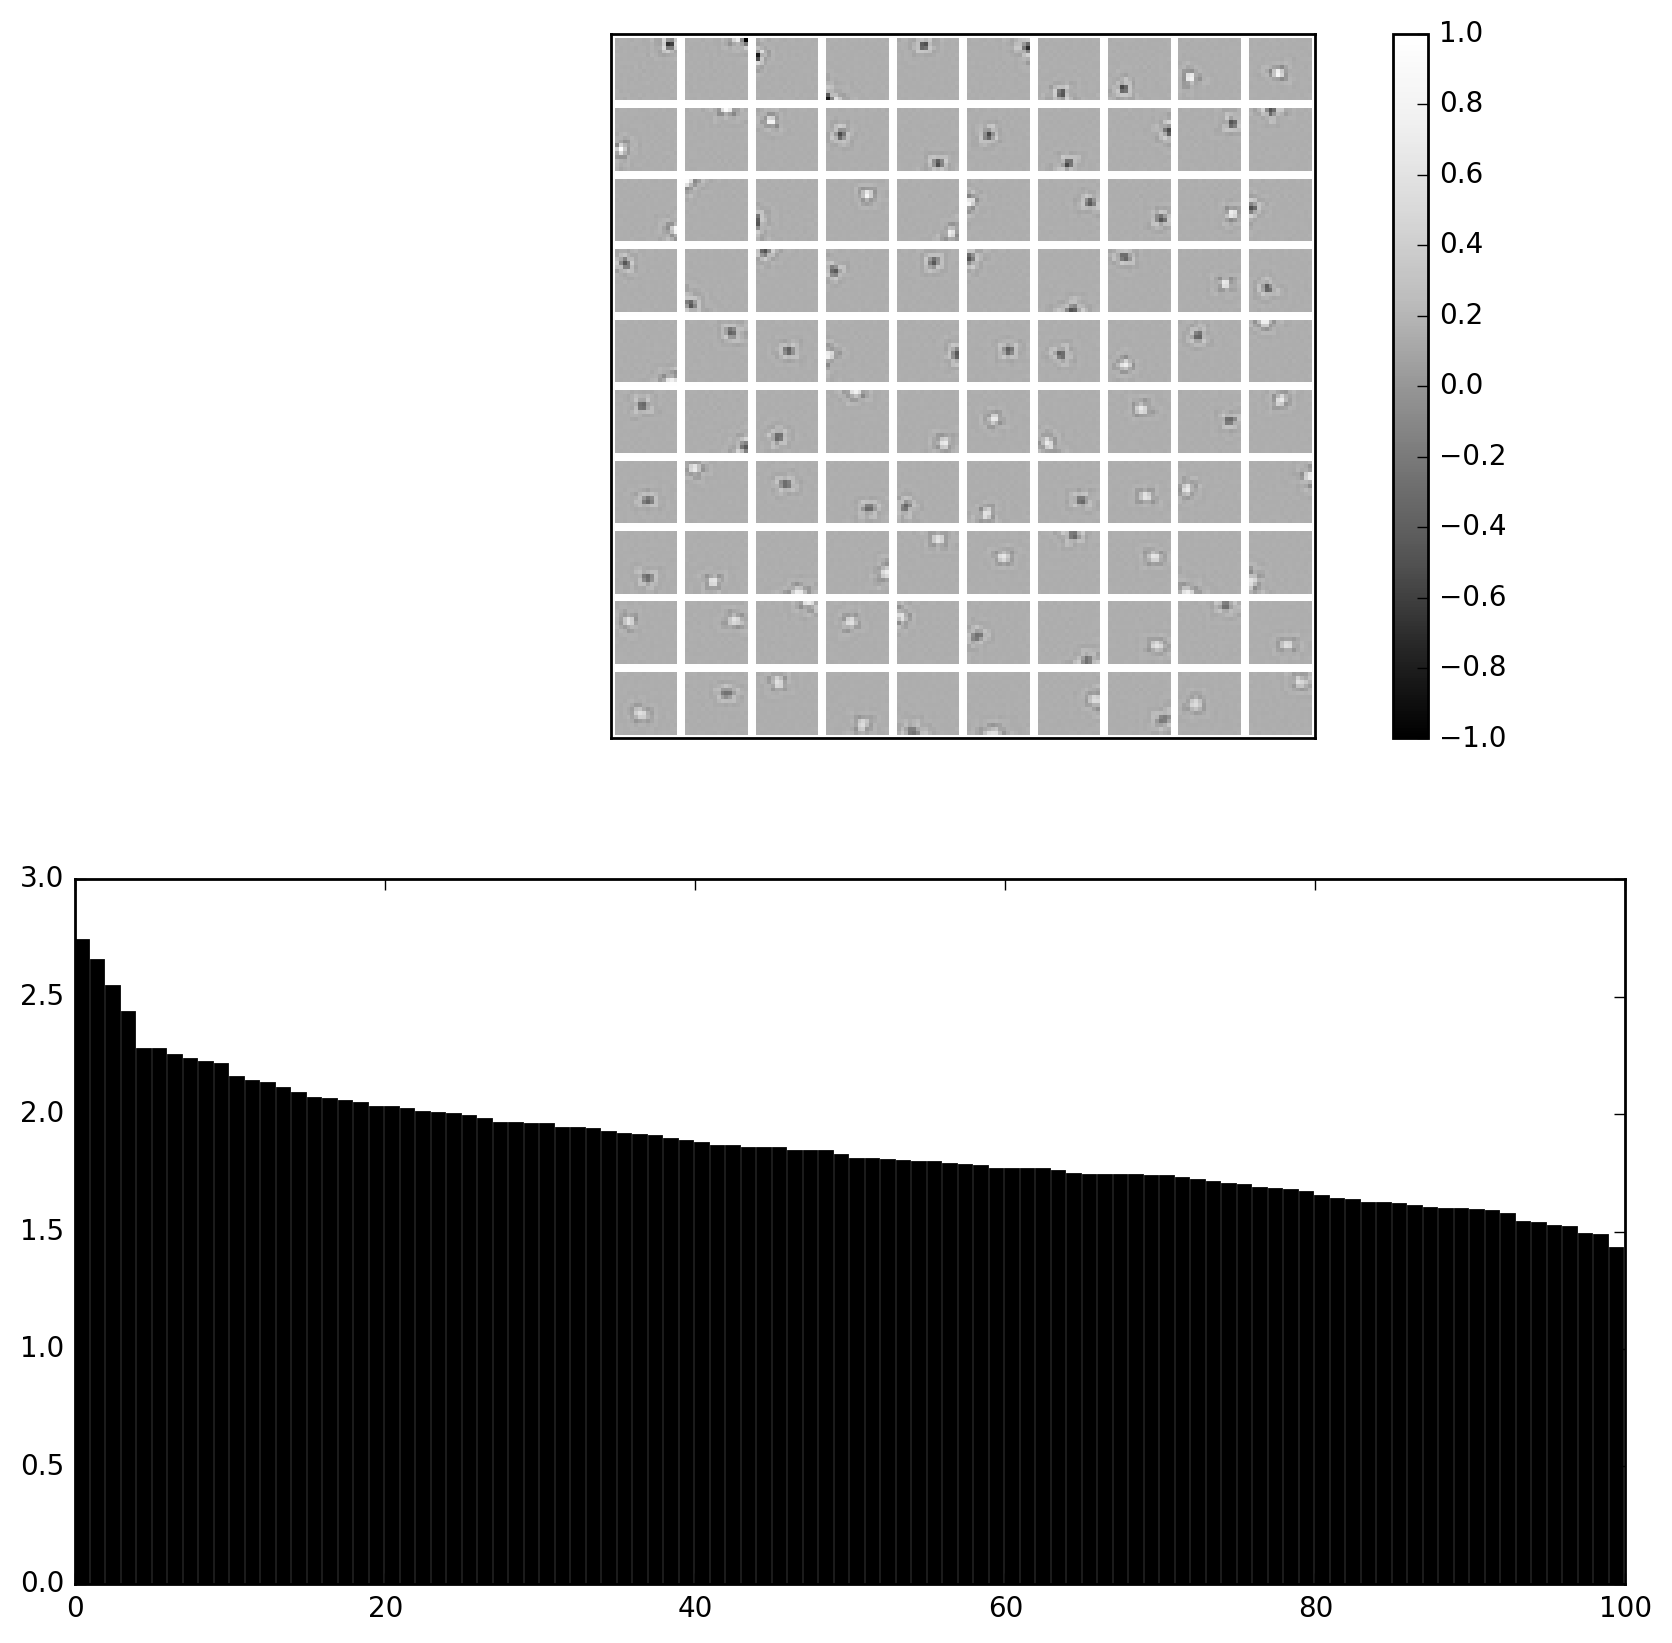

In [30]:
inweights_evolution_r = np.rollaxis(np.reshape(inweights_evolution,
                                                 (len(inweights_evolution),
                                                  aec.params['imxlen'],
                                                  aec.params['imylen'],
                                                    aec.params['nneurons'])),3,1)


plu.display_data_tiled(inweights_evolution_r[-1])

/home/vasha/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/vasha/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


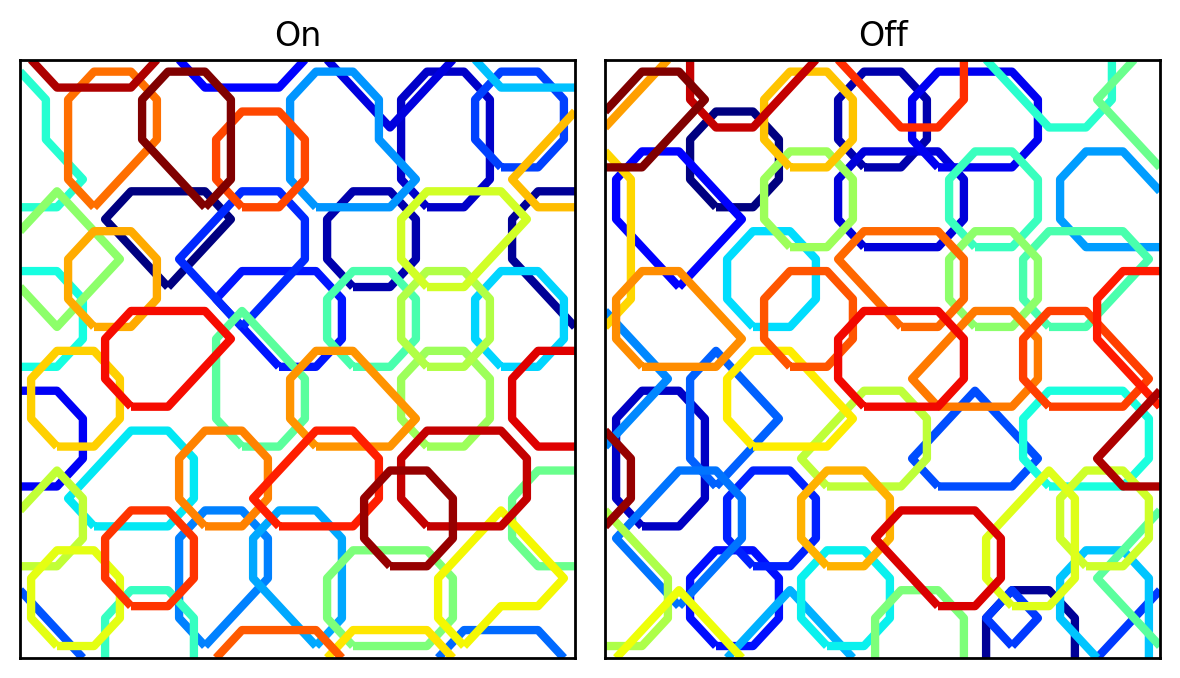

In [33]:
imp.reload(plu)
plu.plotonoff(inweights_evolution_r[-1])